# Muse EEG

In this notebook we will train a model to associate EEG signals from the Muse 2 headset with the wearer's eyes being open or closed.

## Running a Survey

First we can import our library and create a survey, so we can train a model on the resulting data. We'll ask the participant to first get into a comfortable position, then open eyes for 30s, close for 30s, etc.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Next step -- Just breathe normally, gently relax any tension, get in a comfortable position.
Next step -- Please open your eyes.


<IPython.core.display.Javascript object>


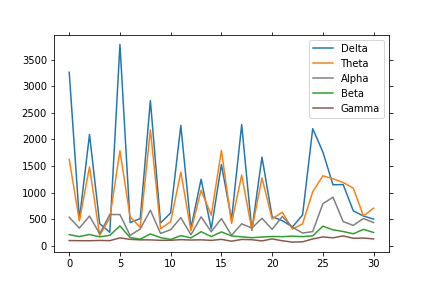

Successfully connected to muse device
Muse 2 Sample rate: 256
Muse 2 time correction: 1624653387.7401052
Next step -- Please close your eyes.


<IPython.core.display.Javascript object>


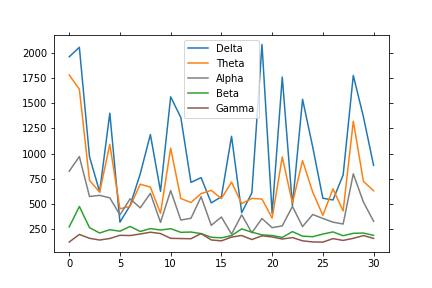

Next step -- Please open your eyes.


<IPython.core.display.Javascript object>


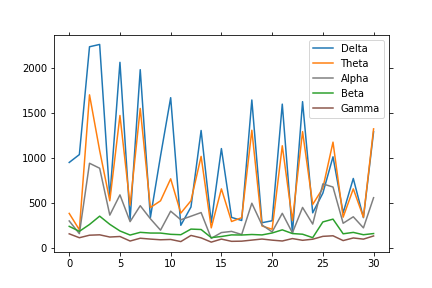

Next step -- Please close your eyes.


<IPython.core.display.Javascript object>


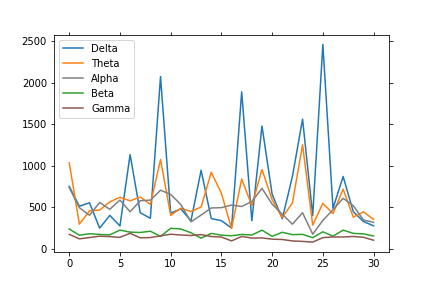

Next step -- Please open your eyes.


<IPython.core.display.Javascript object>


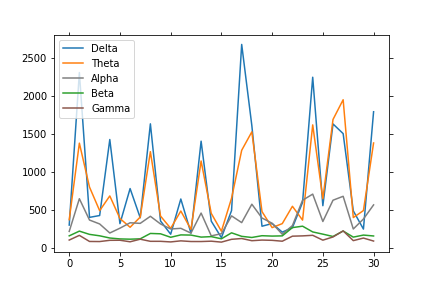

Next step -- Please close your eyes.


<IPython.core.display.Javascript object>


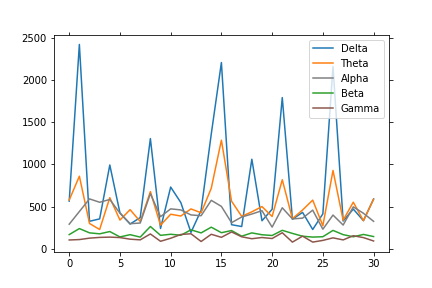

Next step -- Survey Completed. Thank you.


'../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-26 19:47:04.476104'

In [134]:
%matplotlib notebook
# Reload external source files when they change
%load_ext autoreload
%autoreload 2
import sys
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../src")
from recorder import Muse2EEGRecorder
from survey import Survey

eyes_open_step = (timedelta(seconds=30), "eyes_open", "Please open your eyes.", True)
eyes_closed_step = (timedelta(seconds=30), "eyes_closed", "Please close your eyes.", True)
eyes_schedule = [
    (timedelta(seconds=30), "intro", "Just breathe normally, gently relax any tension, get in a comfortable position.", False),
    eyes_open_step,
    eyes_closed_step,
    eyes_open_step,
    eyes_closed_step,
    eyes_open_step,
    eyes_closed_step
]

test_schedule = [
    (timedelta(seconds=5), "intro", "Just breathe normally, gently relax any tension, get in a comfortable position.", True)
]

muse2_recorder = Muse2EEGRecorder()
eyes_survey = Survey(muse2_recorder, "Eyes open-closed", "Eyes open for 30, closed for 30 - repeat 3x.", eyes_schedule)
eyes_survey.record("Jared")

## Preparing Data for Learning

We need to transform our raw survey data into a format suitable for supervised learning. We will create an input tensor with the shape required by PyTorch - `(batch_size, kernel_size, seq_len)`, aka `(Samples, Variables, Length / time or sequence steps)`, or `[batch_size, channels, num_features (aka: H * W)]`.

1. Batch size can be tuned. We will start with `64`.
2. The second index is the number of features per batch. In this case, we have four EEG sensors, so that will be `4`.
3. The number of samples included for each feature in each batch. This must be the same for every batch, so we will need to use a size <= the size of the smallest dataset we will use.

The PyTorch `DataLoader` is an alternative to batching out data manually. After creating a `Dataset`, the DataLoader will batch data with a given batch size.

In [137]:
import os
import torch
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    """
    Given pre-loaded EEG data and labels, split into batches with `num_features` samples per batch.
    """
    def __init__(self, data, labels, num_features, transform=None, target_transform=None):
        self.data = data
        self.labels = labels
        self.num_features = num_features
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return int(len(self.labels) / self.num_features)

    def __getitem__(self, idx):
        start_i = int(idx * self.num_features)
        end_i = start_i + self.num_features
        datum = self.data[start_i:end_i]
        #label = self.labels[start_i:end_i]
        label = self.labels[end_i]
        if self.transform:
            datum = self.transform(datum)
        if self.target_transform:
            label = self.target_transform(label)
        return datum.T, label
    
class EEGSurveyDataset(Dataset):
    """
    Given a survey path, load each eeg_raw csv file and load it as a datum.
    """
    def __init__(self, survey_path, max_size, transform=None, target_transform=None):
        self.data_files = [survey_path + "/" + f for f in os.listdir(survey_path) if f.endswith("eeg_raw.csv")]
        self.label_map = {f:self._parse_filename(f)[1] for f in self.data_files}
        self.ilabel_map = self._create_ilabel_map()
        print(self.ilabel_map)
        self.max_size = max_size
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        data_file = self.data_files[idx]
        data = pd.read_csv(data_file)[["eeg1", "eeg2", "eeg3", "eeg4"]].to_numpy()[:self.max_size]
        label = self.ilabel_map[self.label_map[data_file]]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return torch.from_numpy(data.T), label
    
    def _create_ilabel_map(self):
        ilabel_map = {}
        for key in self.label_map.keys():
            if key not in ilabel_map:
                ilabel_map[self.label_map[key]] = len(ilabel_map.keys())-1
        return ilabel_map
    
    def _parse_filename(self, filename):
        filename = filename.split("/")[-1]
        name, extension = filename.split(".", 1)
        num_tag, typ = name.split("-", 1)
        num, tag = num_tag.split("_", 1)
        return num, tag

def transform_normalize(data):
    for ch in range(data.shape[0]):
        data[ch] = (data[ch] - data[ch].mean()) / data[ch].std()
    return data

# Create PyTorch Datasets
train_dataset = EEGSurveyDataset("../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-26 16:01:52.123715", 256, transform=transform_normalize)
test_dataset = EEGSurveyDataset("../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-26 16:33:30.120561", 256, transform=transform_normalize)
test2_dataset = EEGSurveyDataset("../data/muse2-recordings/surveys/Eyes open-closed Jared 2021-06-26 19:47:04.476104", 256, transform=transform_normalize)
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
test2_dataloader = DataLoader(test2_dataset, batch_size=1, shuffle=True)

{'eyes_open': 0, 'eyes_closed': 1}
{'eyes_open': 0, 'eyes_closed': 1}
{'eyes_open': 0, 'eyes_closed': 1}


## PyTorch Model

Now we can create the neural network we will be training on the collected data. We will model it after the [simple BCI model by Sentdex](https://github.com/Sentdex/BCI).

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F

hidden_layers_size = 64
n_channels = 4
n_outputs = 2

# Create model
net = nn.Sequential(
    # Pass input to a 1D convolutional layer with a kernel size of 3, apply to activation function.
    nn.Conv1d(n_channels, hidden_layers_size, 3),
    nn.ReLU(),

    # Pass previous layer output to a 1D convolutional layer with a kernel size of 2, apply to activation function,
    # and get the max value from each kernel.
    nn.Conv1d(hidden_layers_size, hidden_layers_size, 2),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # Pass previous layer output to a 1D convolutional layer with a kernel size of 2, apply to activation function,
    # and get the max value from each kernel. (same as previous layer)
    nn.Conv1d(hidden_layers_size, hidden_layers_size, 2),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # Flatten the convolutions. Input shape: (a, b, c), Output shape: (a, b*c)
    nn.Flatten(),
    
    # ?
    # XXX: The first number needs to be updated each time the input shapes change. We could instead
    #      Create a class-based Module, and do a single pass through the conv portion of the network
    #      in order to determine the actual size.
    #      (This technique is shown in https://www.youtube.com/watch?v=1gQR24B3ISE&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh&index=7).
    #      For now, we can update this value as needed by commenting out all layers after Flatten(), then running the code
    #      below and inspecting the output shape. The x[1] value should be the first arg in the following line.
    nn.Linear(3968, 512), # ~= nn.LazyLinear(512)
    nn.ReLU(),

    # ?
    nn.Linear(512, n_outputs),
    nn.Softmax()
)

for i, data in enumerate(train_dataloader, 0):
    features, labels = data
    print("Model input shape:", features.shape)
    out = net(features.float())
    print("Model output shape:", out.shape)
    print(out)
    break

Model input shape: torch.Size([1, 4, 256])
Model output shape: torch.Size([1, 2])
tensor([[0.5009, 0.4991]], grad_fn=<SoftmaxBackward>)


### Training the model

/home/jared/.local/share/virtualenvs/neurothink--t8FFcF9/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Final Loss: 0.3132625222206116


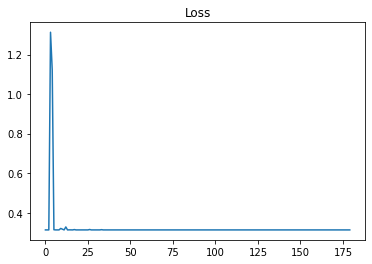

In [133]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train for n epochs
n = 30
loss_history = []
net.train()
for epoch in range(n):
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data

        # Zero gradients
        optimizer.zero_grad()
        #net.zero_grad()

        # Forward
        predictions = net(features.float())
        
        # Compute loss
        loss = criterion(predictions, labels.long())
        loss_history.append(loss.item())
        
        # Backward
        loss.backward()
        
        # Optimize
        optimizer.step()

loss_history = np.array(loss_history)
print("Final Loss:", loss_history[-1])

%matplotlib inline
plt.title("Loss")
plt.plot(loss_history)
plt.show()

In [138]:
net.eval()
total = 0
correct = 0
with torch.no_grad():
    for i, data in enumerate(test2_dataloader, 0):
        features, labels = data
        out = net(features.float())
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        print(labels.size(), preds.size(), out.size())
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print("Correct:", correct, "/", total)

/home/jared/.local/share/virtualenvs/neurothink--t8FFcF9/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([1]) torch.Size([1]) torch.Size([1, 2])
torch.Size([1]) torch.Size([1]) torch.Size([1, 2])
torch.Size([1]) torch.Size([1]) torch.Size([1, 2])
torch.Size([1]) torch.Size([1]) torch.Size([1, 2])
torch.Size([1]) torch.Size([1]) torch.Size([1, 2])
torch.Size([1]) torch.Size([1]) torch.Size([1, 2])
Correct: 2 / 6
